In [33]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [34]:
#loading data

train_path = 'train-metadata.csv'
test_path = 'test-metadata.csv'

train_metadata = pd.read_csv(train_path)
test_metadata = pd.read_csv(test_path)

train_metadata

/var/folders/pj/k78tnlfd70x2r6r2m3x__yq40000gn/T/ipykernel_12287/3402004967.py:6: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train_metadata = pd.read_csv(train_path)


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401054,ISIC_9999937,0,IP_1140263,70.0,male,anterior torso,6.80,TBP tile: close-up,3D: XP,22.574335,...,IL_9520694,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999988
401055,ISIC_9999951,0,IP_5678181,60.0,male,posterior torso,3.11,TBP tile: close-up,3D: white,19.977640,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999820
401056,ISIC_9999960,0,IP_0076153,65.0,female,anterior torso,2.05,TBP tile: close-up,3D: XP,17.332567,...,IL_9852274,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999416
401057,ISIC_9999964,0,IP_5231513,30.0,female,anterior torso,2.80,TBP tile: close-up,3D: XP,22.288570,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,100.000000


In [35]:
#data preperation part, checking for null values

missing_val = train_metadata.isnull().sum()
print("Missing Values:\n", missing_val)

Missing Values:
 isic_id                              0
target                               0
patient_id                           0
age_approx                        2798
sex                              11517
anatom_site_general               5756
clin_size_long_diam_mm               0
image_type                           0
tbp_tile_type                        0
tbp_lv_A                             0
tbp_lv_Aext                          0
tbp_lv_B                             0
tbp_lv_Bext                          0
tbp_lv_C                             0
tbp_lv_Cext                          0
tbp_lv_H                             0
tbp_lv_Hext                          0
tbp_lv_L                             0
tbp_lv_Lext                          0
tbp_lv_areaMM2                       0
tbp_lv_area_perim_ratio              0
tbp_lv_color_std_mean                0
tbp_lv_deltaA                        0
tbp_lv_deltaB                        0
tbp_lv_deltaL                        0
tbp_lv_d

In [36]:
# list of columns we want to remove
columns_to_remove = ['lesion_id', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5', 'mel_mitotic_index', 'mel_thick_mm']

#specify these columns
train_metadata_cleaned = train_metadata.drop(columns=columns_to_remove, errors='ignore')

# remove rows with 0 values
train_metadata_cleaned_no_nulls = train_metadata_cleaned.dropna()

In [37]:
# showing the unique values in target = understand the distribution of data in that column
train_metadata_cleaned_no_nulls['target'].value_counts()

target
0    381533
1       381
Name: count, dtype: int64

In [38]:
# the data is imbalanced

# separate the classes based on 'target' column
class_0 = train_metadata_cleaned_no_nulls[train_metadata_cleaned_no_nulls['target'] == 0]
class_1 = train_metadata_cleaned_no_nulls[train_metadata_cleaned_no_nulls['target'] == 1]

# downsample class 0 to class 1
class_0_downsampled = resample(class_0,
                               replace=False,  # sample without replacement
                               n_samples=len(class_1),  # match classes size
                               random_state=42) 

# combine the downsampled majority class with the minority class
balanced_data = pd.concat([class_0_downsampled, class_1])


print("Shape of balanced data:", balanced_data.shape)
print("Distribution after balancing:\n", balanced_data['target'].value_counts())


Shape of balanced data: (762, 48)
Distribution after balancing:
 target
0    381
1    381
Name: count, dtype: int64


In [39]:
train_metadata_balanced = balanced_data

/var/folders/pj/k78tnlfd70x2r6r2m3x__yq40000gn/T/ipykernel_12287/734578827.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='sex', y='age_approx', data=filtered_data_target_1, palette=['pink', 'blue'], ax=axes[0])
/var/folders/pj/k78tnlfd70x2r6r2m3x__yq40000gn/T/ipykernel_12287/734578827.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='sex', y='age_approx', data=filtered_data_target_0, palette=['pink', 'blue'], ax=axes[1])


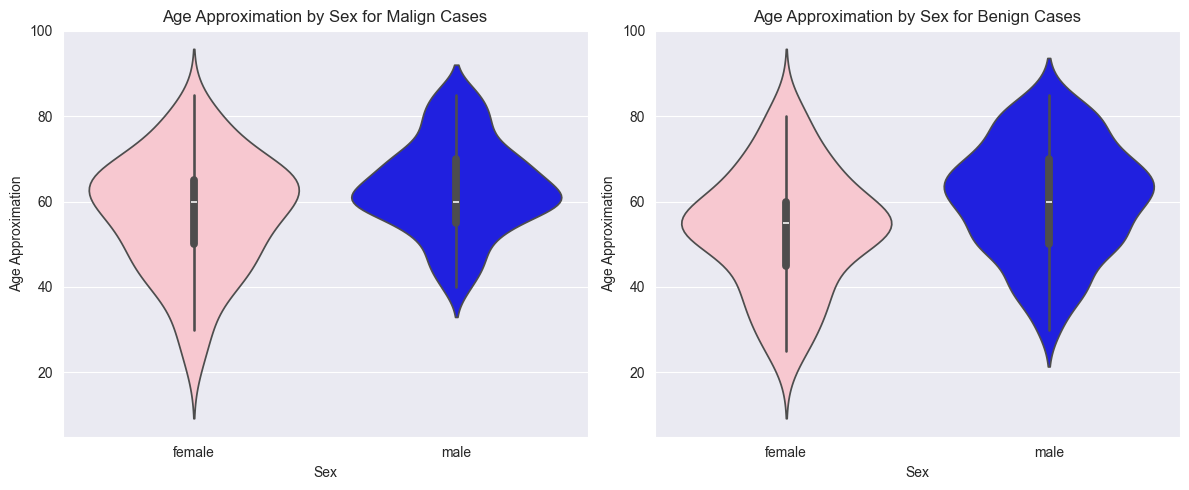

In [40]:
# visualizing part

# filter the data to focus on a specific subset of the data
filtered_data_target_1 = train_metadata_balanced[train_metadata_balanced['target'] == 1]
filtered_data_target_0 = train_metadata_balanced[train_metadata_balanced['target'] == 0]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# plot for target 1 (malign cases)
sns.violinplot(x='sex', y='age_approx', data=filtered_data_target_1, palette=['pink', 'blue'], ax=axes[0])
axes[0].set_title('Age Approximation by Sex for Malign Cases')
axes[0].set_xlabel('Sex')
axes[0].set_ylabel('Age Approximation')

# plot for target 0 (benign cases)
sns.violinplot(x='sex', y='age_approx', data=filtered_data_target_0, palette=['pink', 'blue'], ax=axes[1])
axes[1].set_title('Age Approximation by Sex for Benign Cases')
axes[1].set_xlabel('Sex')
axes[1].set_ylabel('Age Approximation')

plt.tight_layout()
plt.show()


### We can see from the violin plot that women are more likely than males to develop skin cancer.

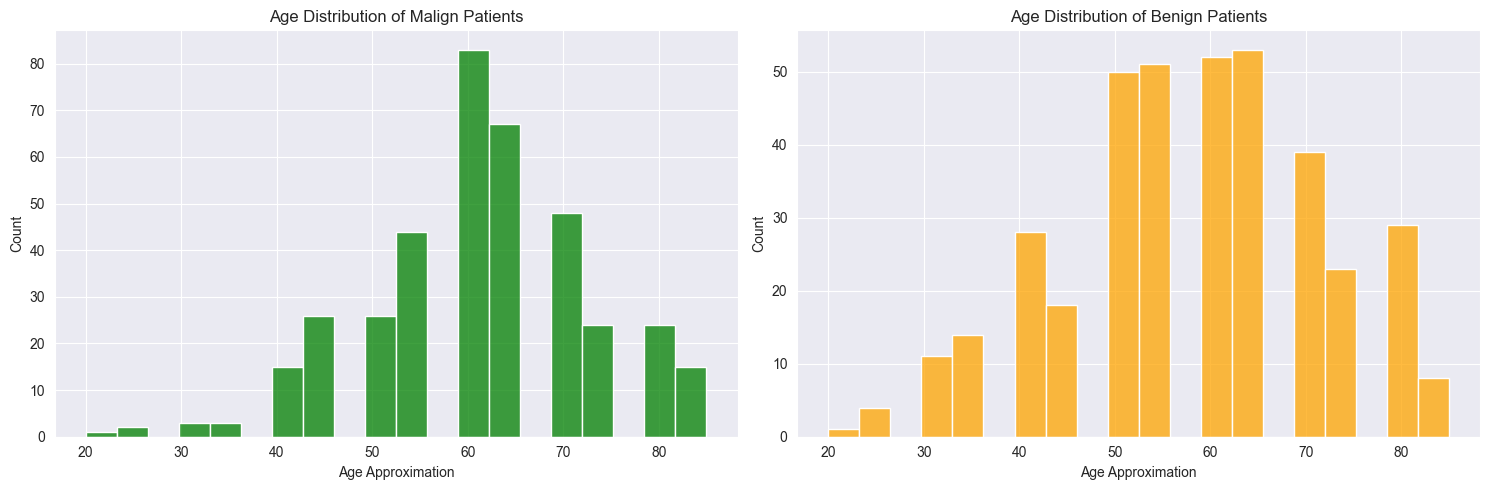

In [41]:
fig, axes1 = plt.subplots(1, 2, figsize=(15, 5))

# malign cases (target=1)
sns.histplot(filtered_data_target_1['age_approx'].dropna(), bins=20, color='green', ax=axes1[0])
axes1[0].set_title('Age Distribution of Malign Patients')
axes1[0].set_xlabel('Age Approximation')
axes1[0].set_ylabel('Count')

# benign cases (target=0)
sns.histplot(filtered_data_target_0['age_approx'].dropna(), bins=20, color='orange', ax=axes1[1])
axes1[1].set_title('Age Distribution of Benign Patients')
axes1[1].set_xlabel('Age Approximation')
axes1[1].set_ylabel('Count')


plt.tight_layout()
plt.show()


### Benign are more widely distributed, but malignant cases are more concentrated between the ages of 50 and 70.

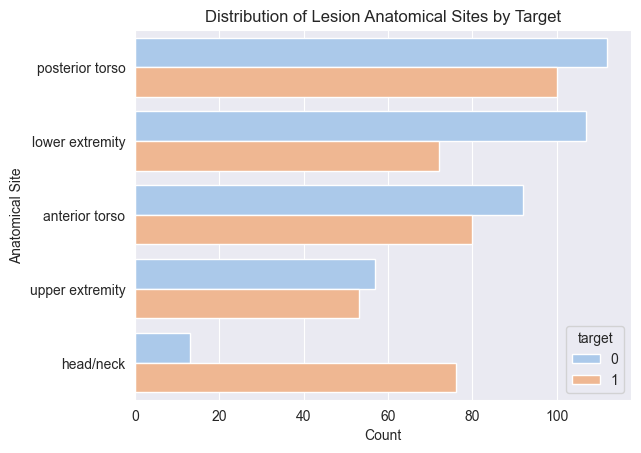

In [42]:
sns.countplot(y='anatom_site_general', data=train_metadata_balanced, palette='pastel', order=train_metadata_balanced['anatom_site_general'].value_counts().index,
              hue='target')  # separate target 0 and target 1

plt.title('Distribution of Lesion Anatomical Sites by Target')
plt.xlabel('Count')
plt.ylabel('Anatomical Site')

plt.show()

###  Lesions are often found on the torso and lower limbs in benign cases, with less frequency on the head/neck. While malign cases has occurred everywhere almost the same way, even in the head/neck.

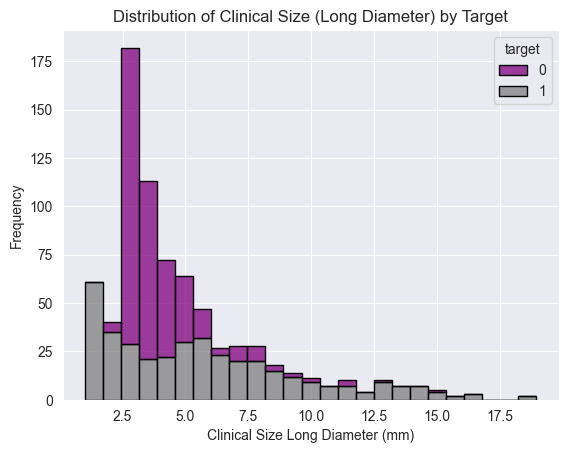

In [43]:
sns.histplot(data=train_metadata_balanced, 
             x='clin_size_long_diam_mm',hue='target', bins=25, color='lightcoral',
             edgecolor='black', multiple="stack", palette=['purple', 'grey'])  # for easier comparison


plt.title('Distribution of Clinical Size (Long Diameter) by Target')
plt.xlabel('Clinical Size Long Diameter (mm)')
plt.ylabel('Frequency')


plt.show()

### Lesions in Benign cases (Target 0) are primarily focused on smaller sizes, whereas Malign cases(Target 1) presents a more diverse size distribution.

# model implimentation with CNN (Binary Image Classification) and DNN (fully connected Dense Neural Network)

In [54]:
# Importing necessary libraries
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.metrics import classification_report
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

In [55]:
data = train_metadata_balanced.dropna()  # Drop missing values if any
data = pd.get_dummies(data)# Convert categorical variables to dummy/indicator variables because there is a non-numeric value in the features  that cannot be converted to a float.

# Features and target
X = data.drop(columns=['target'])
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)# Split the data

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### model implimentation with CNN (Binary Image Classification)


In [57]:
# Pad each sample to reach 1296 features
X_padded = np.pad(X_scaled, ((0, 0), (0, 3)), 'constant')  # Pads each sample with 3 zeros

# Reshape the padded data for CNN input
num_samples = X_padded.shape[0]
X_reshaped = X_padded.reshape(num_samples, 36, 36, 1)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

# Define the CNN model with updated input shape (36, 36, 1)
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(36, 36, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # Assuming binary classification
])


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [58]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [59]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5113 - loss: 0.7518 - val_accuracy: 0.5164 - val_loss: 0.7292
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7510 - loss: 0.5554 - val_accuracy: 0.5492 - val_loss: 0.7050
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8419 - loss: 0.4453 - val_accuracy: 0.5656 - val_loss: 0.7361
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8949 - loss: 0.3145 - val_accuracy: 0.5246 - val_loss: 0.8917
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9416 - loss: 0.2005 - val_accuracy: 0.5574 - val_loss: 0.9209
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9713 - loss: 0.1349 - val_accuracy: 0.5328 - val_loss: 1.0397
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9894 - loss: 0.0690 - val_accuracy: 0.5492 - val_loss: 1.2368
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9902 - loss: 0.0398 - val_accuracy: 0.5574 - v

In [60]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Accuracy: {accuracy}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5402 - loss: 2.1740 
Accuracy: 0.5424836874008179


In [61]:
# Generate predictions on the test set
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions (0 or 1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


In [62]:
# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.59      0.56        74
           1       0.57      0.49      0.53        79

    accuracy                           0.54       153
   macro avg       0.54      0.54      0.54       153
weighted avg       0.55      0.54      0.54       153



In [18]:
# Save the model
model.save('skin_cancer_cnn_model.h5')


### model implementation with DNN (fully connected Dense Neural Network)

In [63]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [64]:
# Initialize the Dense neural network model
model = Sequential([
    Dense(512, activation='relu', input_shape=(1293,)),
    Dropout(0.3),  # Dropout layer to prevent overfitting
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
])

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [65]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [66]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5458 - loss: 0.8386 - val_accuracy: 0.7213 - val_loss: 0.5250
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7940 - loss: 0.4221 - val_accuracy: 0.9180 - val_loss: 0.2317
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9929 - loss: 0.0782 - val_accuracy: 0.9508 - val_loss: 0.1306
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9921 - loss: 0.0305 - val_accuracy: 0.9590 - val_loss: 0.0990
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9937 - loss: 0.0094 - val_accuracy: 0.9672 - val_loss: 0.0854
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0034 - val_accuracy: 0.9590 - val_loss: 0.0809
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 0.9590 - val_loss: 0.0840
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9590 - val_loss

In [68]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Accuracy: {accuracy}")
print(f"Loss: {loss}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9644 - loss: 0.0773 
Accuracy: 0.9542483687400818
Loss: 0.10230834782123566
